In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial
import keras.backend as K
import sys
from keras.datasets import mnist
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# Load Dataset

The dataset consists of about 40000 images 160x160 of valid Tic Tac pills and 1000 images of broken Tic-Tac pills. The dataset can be downloaded from https://tinyurl.com/y3geqpg5.

![alt text](pills.png)


In [38]:
def create_default(train_generator,\
                    res = (160,160),\
                    batch_size = 100,\
                    ftrain = 'tictac_dataset/train/',\
                    ftest  = 'tictac_dataset/test/',\
                    fdefect = 'tictac_dataset/defect/'):
    """
    Generate testset, trainset and set with defects from folder.
    """
    train_datagen = train_generator

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
        ftrain,  # this is the target directory
        target_size=(28,28),  # all images will be resized to res
        batch_size=batch_size,
        color_mode = 'grayscale',
        seed = 42,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

    # this is a similar generator, for validation data
    test_generator = test_datagen.flow_from_directory(
        ftest,
        target_size=(28,28),
        batch_size=batch_size,
        color_mode = 'grayscale',
        seed = 42,
        class_mode='binary')

    testall_generator = test_datagen.flow_from_directory(
        fdefect,
        target_size=res,
        batch_size=batch_size,
        color_mode = 'grayscale',
        seed = 42,
        class_mode='binary')

    return train_generator, test_generator, testall_generator

def generate_dataset(train_generator,\
                     nb_train_samples,\
                     nb_validation_samples,\
                     res=(160,160),\
                     batch_size = 100,\
                     ftrain = 'tictac_dataset/train/',\
                     ftest  = 'tictac_dataset/test/',\
                     fdefect = 'tictac_dataset/defect/'):
    
    train_generator,\
        test_generator,\
        testall_generator = create_default(train_generator,\
                                           res = res,\
                                           batch_size = batch_size,\
                                           ftrain  = ftrain,\
                                           ftest   = ftest,\
                                           fdefect = fdefect)

    # here's a more "manual" example
    all_test = test_generator.next()[0]
    all_train = train_generator.next()[0]

    batches = 0
    for inp in train_generator:
        batches+=1
        all_train = np.vstack((all_train, inp[0]))
        if batches >= nb_train_samples/batch_size-1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    batches = 0    
    for inp in test_generator:
        batches+=1
        all_test  = np.vstack((all_test, inp[0]))
        if batches >= nb_validation_samples/batch_size-1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return all_train, all_test

In [39]:
tr_gen = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rescale = 1./255,
    shear_range = 0.0,
    rotation_range = 0,
    width_shift_range = 0.,
    height_shift_range = 0.,
    zoom_range = 0.0,
    horizontal_flip=False)

x_train, x_test = generate_dataset(tr_gen,nb_train_samples = 10000, nb_validation_samples = 5000)

Found 32814 images belonging to 1 classes.
Found 5790 images belonging to 1 classes.
Found 1009 images belonging to 1 classes.


In [40]:
x_train.shape

(10000, 28, 28, 1)

In [41]:
img_shape = (28,28,1)
latent_dim  = 20
channels = 1
BATCH_SIZE = 128

In [42]:
def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_critic():

    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


In [43]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

#real_img, fake_img
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [44]:
optimizer = RMSprop(lr=0.00005)

generator = build_generator()
critic = build_critic()

critic.trainable = True
generator.trainable = False

# Image input (real sample)
real_img = Input(shape=img_shape)

# Noise input
z_disc = Input(shape=(latent_dim,))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

critic = build_critic()
# Discriminator determines validity of the real and fake images
fake = critic(fake_img)
valid = critic(real_img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              131712    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 128)       0         
__________

In [45]:
# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
# Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

# Use Python partial to provide loss function with additional
# 'averaged_samples' argument
partial_gp_loss = partial(gradient_penalty_loss,
                  averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names



critic_model = Model(inputs=[real_img, z_disc],
                    outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,
                            wasserstein_loss,
                            partial_gp_loss],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 10])



In [46]:
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------
critic.trainable = False
generator.trainable = True
# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

In [47]:
corr_metrics=[]

In [48]:
n_critic = 2
epochs=100
batch_size = BATCH_SIZE
valid = -np.ones((batch_size, 1))
fke =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
for epoch in tqdm(range(epochs)):
    for _ in range(n_critic):
        critic.trainable = True
        generator.trainable = False

        idx = np.random.randint(0, len(x_train), batch_size)
        data_batch = x_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        d_loss = critic_model.train_on_batch([data_batch, noise], [valid, fke, dummy])
    critic.trainable = False
    generator.trainable = True
    g_loss = generator_model.train_on_batch(noise, valid)
    corr_metrics.append([g_loss, d_loss])

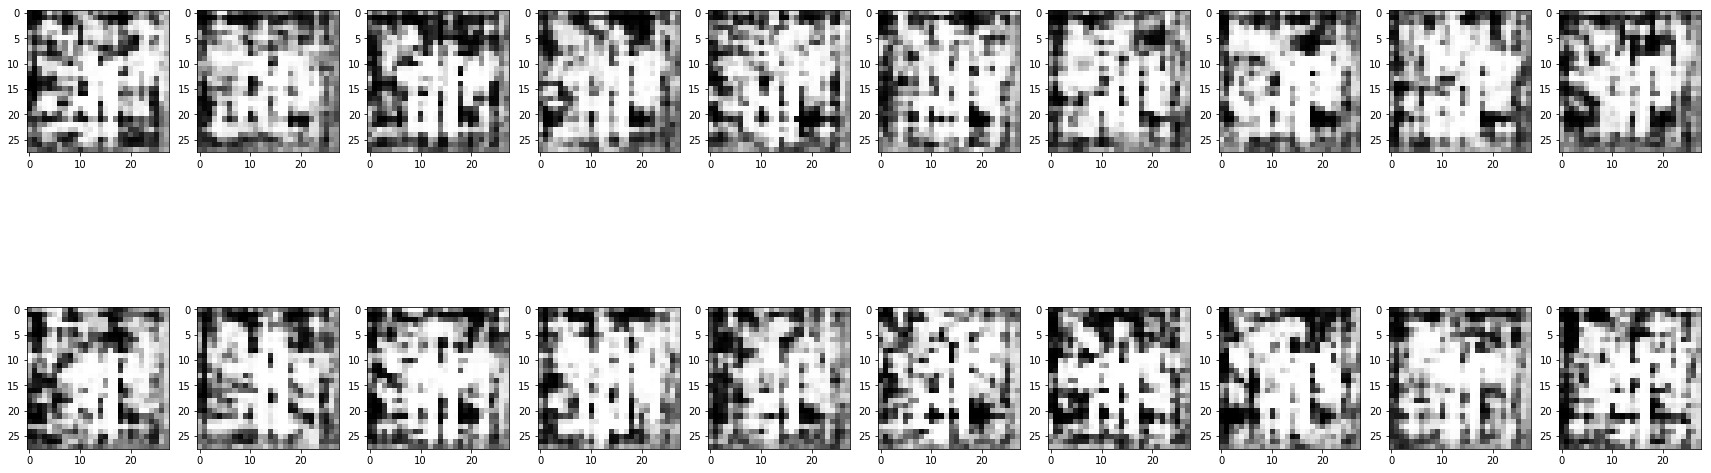

In [49]:
ar = np.random.normal(0, 1, (latent_dim*21))
fake = generator.predict(ar.reshape(-1,latent_dim))
plt.figure(figsize=(30,10))
for ni, i in enumerate(fake[:20]):
    plt.subplot(2,10,ni+1)
    plt.imshow((i.reshape(28,28)),'gray')
plt.show()